In [102]:
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict
import pdb
import matplotlib.pyplot as plt
from math import sqrt, ceil
import numpy as np
import torch
from torch.autograd import Variable
from PIL import Image
from functools import partial
import sys
import cv2

In [103]:
class VGG16_Conv(nn.Module):

    def __init__(self, n_classes = 1000):   # ImageNet class categories
        super(VGG16_Conv, self).__init__()

        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv2
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv3
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv4
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv5
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # 224x244 image pooled down to 7x7 from features
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, n_classes)
        )

        self.feat_maps = OrderedDict()  # store all (conv) feature maps

        self.pool_locs = OrderedDict() # store all max locations for pooling layers

        # index of convolutional layers
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

        self.init_weights() # initialize weights

    # initialize weights using pre-trained vgg16 on ImageNet
    def init_weights(self):
        vgg16_pretrained = models.vgg16(pretrained = True)
        for idx, layer in enumerate(vgg16_pretrained.features): # feature component
            if isinstance(layer, nn.Conv2d):
                self.features[idx].weight.data = layer.weight.data
                self.features[idx].bias.data = layer.bias.data

        for idx, layer in enumerate(vgg16_pretrained.classifier):   # classifier component
            if isinstance(layer, nn.Linear):
                self.classifier[idx].weight.data = layer.weight.data
                self.classifier[idx].bias.data = layer.bias.data

    def forward(self, x):
        for idx, layer in enumerate(self.features): # pass self.features
            if isinstance(layer, nn.MaxPool2d):
                x, locs = layer(x)
            else:
                x = layer(x)

        x = x.view(x.size()[0], -1) # reshape to (1, 512 * 7 * 7)

        output = self.classifier(x) # pass self.classifier

        return output
    
    # store all feature maps and max pooling locations during forward pass
    def store_feat_maps(self):
        
        def hook(module, inp, output, key):
            if isinstance(module, nn.MaxPool2d):
                self.feat_maps[key] = output[0]
                self.pool_locs[key] = output[1]
            else:
                self.feat_maps[key] = output

        for idx, layer in enumerate(self._modules.get('features')):    # _modules returns an OrderedDict
            layer.register_forward_hook(partial(hook, key = idx))

In [104]:
class VGG16_Deconv(nn.Module):

    def __init__(self):
        super(VGG16_Deconv, self).__init__()

        self.features = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            # deconv2
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding = 1),
            # deconv3
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding = 1),
            # deconv4
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding = 1),
            # deconv5
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding = 1)
        )

        # forward idx : backward idx
        self.conv2deconv_indices = {0:30, 2:28, 5:25, 7:23, 10:20, 12:18, 14:16, 17:13, 19:11, 21:9, 24:6, 26:4, 28:2}
        # forward idx : backward idx; not align
        self.conv2deconv_bias_indices = {0:28, 2:25, 5:23, 7:20, 10:18, 12:16, 14:13, 17:11, 19:9, 21:6, 24:4, 26:2}
        # forwardidx : backward idx
        self.relu2relu_indices = {1:29, 3:27, 6:24, 8:22, 11:19, 13:17, 15:15, 18:12, 20:10, 22:8, 25:5, 27:3, 29:1}
        # backward idx : forward idx
        self.unpool2pool_indices = {26:4, 21:9, 14:16, 7:23, 0:30}

        self.init_weights()  # initialize weights

    # initialize weights using pre-trained vgg16 on ImageNet
    def init_weights(self):
        vgg16_pretrained = models.vgg16(pretrained = True)
        for idx, layer in enumerate(vgg16_pretrained.features): # feature component
            if isinstance(layer, nn.Conv2d):
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                if idx in self.conv2deconv_bias_indices:    # bias in first backward layer is randomly set
                    self.features[self.conv2deconv_bias_indices[idx]].bias.data = layer.bias.data

    def forward(self, x, layer, activation_idx, pool_locs):
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        elif layer in self.relu2relu_indices:
            start_idx = self.relu2relu_indices[layer]
        else:
            print('No such Conv2d or RelU layer!')
            sys.exit(0)

        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                x = self.features[idx](x, pool_locs[self.unpool2pool_indices[idx]])
            else:
                x = self.features[idx](x)

        return x

In [105]:
# transform and normalize a deconvolutional output image
def tn_deconv_img(deconv_output):
    img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)

    return img

In [106]:
# visualize a feature map in a grid
def vis_grid(feat_map): # feat_map: (C, H, W, 1)
    (C, H, W, B) = feat_map.shape
    cnt = int(ceil(sqrt(C)))
    G = np.ones((cnt * H + cnt, cnt * W + cnt, B), feat_map.dtype)  # additional cnt for black cutting-lines
    G *= np.min(feat_map)

    n = 0
    for row in range(cnt):
        for col in range(cnt):
            if n < C:
                # additional cnt for black cutting-lines
                G[row * H + row : (row + 1) * H + row, col * W + col 
                  : (col + 1) * W + col, :] = feat_map[n, :, :, :]
                n += 1

    # normalize to [0, 1]
    G = (G - G.min()) / (G.max() - G.min())
    return G

# visualize a layer (a feature map represented by a grid)
def vis_layer(feat_map_grid):
    plt.figure(figsize=(20, 20))
    plt.imshow(feat_map_grid[:, :, 0], cmap="gray")   # feat_map_grid: (ceil(sqrt(C)) * H, ceil(sqrt(C)) * W, 1)
    plt.show()

In [107]:
# image loading and preprocessing
def load_image(filename):
    return Image.open(filename)

def preprocess(img):
    img = np.asarray(img.resize((224, 224))) # resize to 224 * 224 (W * H), np.asarray returns (H, W, C)
    img = img.transpose(2, 0, 1)    # reshape to (C, H, W)
    img = img[np.newaxis, :, :, :]  # add one dim to (1, C, H, W)

    return Variable(torch.FloatTensor(img.astype(float)))

In [108]:
img_file = 'dog.png'

# load an image
img = load_image(img_file)

# preprocess an image, return a pytorch Variable
input_img = preprocess(img)

vgg16_conv = VGG16_Conv(1000)   # ImageNet class categories, build vgg16 forward network
_ = vgg16_conv.eval()   # evaluation mode

vgg16_conv.store_feat_maps() # store all feature maps and max pooling locations during forward pass

conv_output = vgg16_conv(input_img)

vgg16_deconv = VGG16_Deconv()   # build vgg16 backward network
_ = vgg16_deconv.eval()

In [109]:
# choose a layer to visualize
layer = 0

# only transpose convolve from Conv2d or ReLU layers
if (layer not in vgg16_conv.conv_layer_indices) and (layer - 1 not in vgg16_conv.conv_layer_indices):
    print('Select a Conv2D or Relu layer')

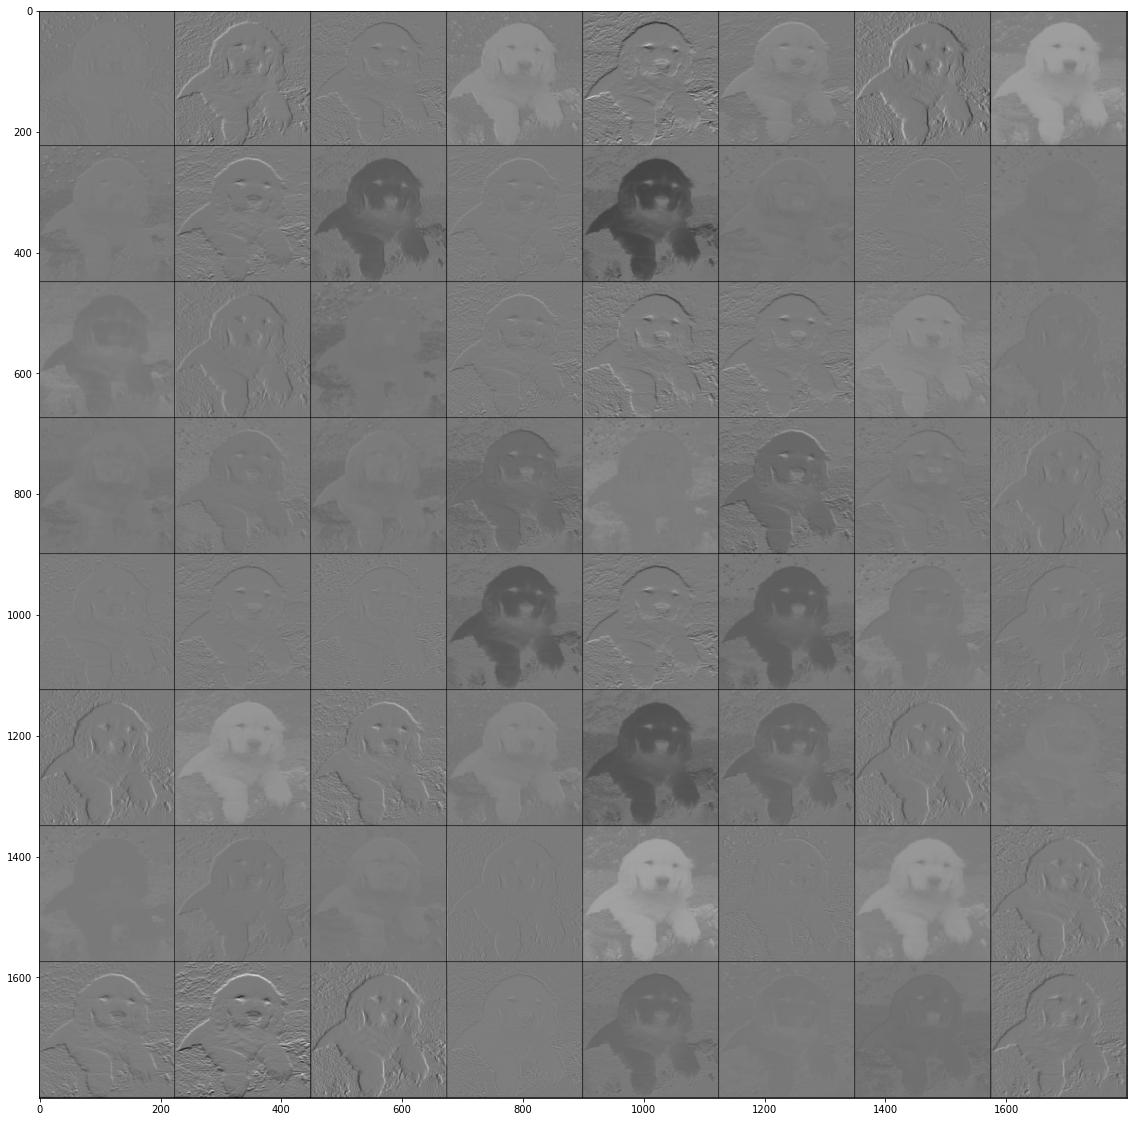

In [110]:
feat_map = vgg16_conv.feat_maps[layer].data.numpy().transpose(1, 2, 3, 0) # (1, C, H, W) -> (C, H, W, 1)

# visualize all feature maps in selected layer
feat_map_grid = vis_grid(feat_map)  # represent a feature map in a grid
vis_layer(feat_map_grid)    # visualize a feature map

In [111]:
# number of activations in the selected layer
n_activation = feat_map.shape[0]
print(n_activation)

# choose an activation to visualize
activation_idx = 10
print(activation_idx)

64
10


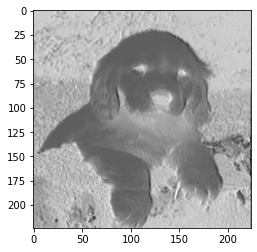

In [112]:
# visualize selected feature map
plt.imshow(feat_map[activation_idx, :, :, 0], cmap="gray")
plt.show()

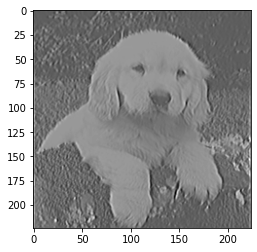

In [114]:
# visualize selected activation in selected layer
new_feat_map = vgg16_conv.feat_maps[layer].clone()

# set all activations to zero, except for the selected one
if activation_idx == 0:
    new_feat_map[:, 1:, :, :] = 0
else:
    new_feat_map[:, :activation_idx, :, :] = 0
    if activation_idx != vgg16_conv.feat_maps[layer].shape[1] - 1:
        new_feat_map[:, activation_idx + 1:, :, :] = 0

deconv_output = vgg16_deconv(new_feat_map, layer, activation_idx, vgg16_conv.pool_locs)

# transform and normalize a deconvolutional image
img = tn_deconv_img(deconv_output)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# heatmap = cv2.applyColorMap(cv2.resize(img, (img.shape[1], img.shape[0])), cv2.COLORMAP_JET)
plt.imshow(cv2.resize(img, (img.shape[1], img.shape[0])), cmap="gray")
plt.show()